In [11]:
import sys
sys.path.append('../')
import attention

(1000, 2)
(1000,)


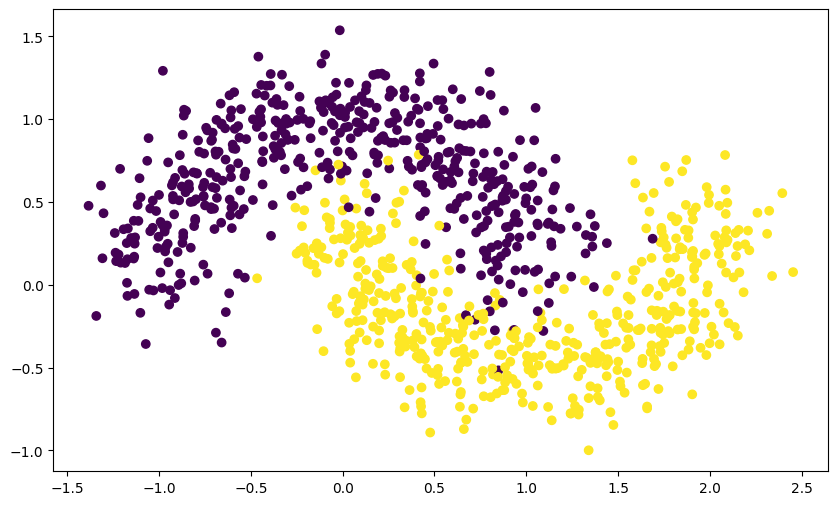

In [12]:
import jax.numpy as jnp
import numpy as np
import jax
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

rng = jax.random.PRNGKey(np.random.randint(0, 10000))

X, Y = make_moons(n_samples=1000, noise=0.2, random_state=0)

print(X.shape)
print(Y.shape)
    
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=Y);


In [13]:
from torch.utils.data import Dataset, DataLoader

class Data(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def __len__(self):
        return len(self.x)

BATCH_SIZE = 1
loader = DataLoader(Data(X, Y), batch_size=BATCH_SIZE, shuffle=True)


In [14]:
from attention import Dense, DenseState, sigmoid, relu
from loss import BCELoss
from jax import random

class Network:
    def __init__(self):
        self.layers = [Dense(2, 50), Dense(50, 50), Dense(50, 1)]

    def __call__(self, state: list[DenseState], x: jax.Array) -> jax.Array:
        for substate, layer in zip(state[:-1], self.layers[:-1]):
            x = relu(layer(substate, x))
        return sigmoid(self.layers[-1](state[-1], x))

    def init_params(self, rng) -> list[DenseState]:
        keys = random.split(rng, len(self.layers))
        return [layer.init_state(key) for layer, key in zip(self.layers, keys)]

net = Network()
states = net.init_params(rng)


In [15]:
import numpy as np
import os

def plot_decision_boundary(net, X, y, epoch = None):
    plt.figure(figsize=(10, 6))
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    mesh_points = np.c_[xx.ravel(), yy.ravel()]

    mesh_probs = net(states, mesh_points).reshape(xx.shape)

    # Create a contour plot to display the decision boundary
    plt.contourf(xx, yy, mesh_probs, levels=[0, 0.5, 1], cmap=plt.cm.RdBu, alpha=0.6)

    # Plot the data points for the two classes
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], c='red', label='Class 0')
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='blue', label='Class 1')

    # Set labels and legend
    plt.legend(loc='best')

    # Display the decision boundary as a solid line
    contours = plt.contour(xx, yy, mesh_probs, levels=[0.5], colors='k', linewidths=1.5)
    plt.clabel(contours, inline=True, fontsize=12)

    # turn off axes
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().get_xaxis().set_ticks([])
    plt.gca().get_yaxis().set_ticks([])
    plt.tight_layout()

    if not os.path.exists('plots'): os.mkdir('plots')
    if epoch is not None: plt.savefig(f'plots/epoch{epoch}.png')
    plt.close()

plt.figure(figsize=(10, 6))
plot_decision_boundary(net, X, Y)

<Figure size 1000x600 with 0 Axes>

In [16]:
batch_predict = jax.vmap(net, in_axes=(None, 0))
loss_fn = BCELoss()

def loss(states, xb, yb):
    pred = batch_predict(states, xb)
    l = loss_fn(pred, yb)
    return l

for xb, yb in loader:
    loss(states, jnp.array(xb), jnp.array(yb))
    break

In [17]:
step_size = 0.01
@jax.jit
def update(states: list[DenseState], xb, yb) -> list[DenseState]:
    grads = jax.grad(loss, argnums=0)(states, xb, yb)
    new_states = []
    for state, grad in zip(states, grads):
        new_weights = state.weights - grad.weights * step_size
        new_bias = state.bias - grad.bias * step_size
        new_states.append(DenseState(new_weights, new_bias))
    return new_states


In [18]:
from IPython.display import clear_output
from tqdm import tqdm

EPOCHS = 80
for epoch in tqdm(range(EPOCHS)):
    for xb, yb in loader:
        states = update(states, jnp.array(xb), jnp.array(yb))

    # clear_output(wait=True)
    plot_decision_boundary(net, X, Y, epoch)

100%|██████████| 80/80 [01:06<00:00,  1.21it/s]


In [19]:
import os
import imageio

image_files = sorted([f'plots/{filename}' for filename in os.listdir('plots')])
images = [imageio.imread(file) for file in image_files]
# imageio.mimsave('decision_boundary.gif', images, duration=0.5)  # Adjust duration as needed

C:\Users\Lukas\AppData\Local\Temp\ipykernel_2824\1984061246.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(file) for file in image_files]
